In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
def stock_data(stock, start_date, end_date):
    tickerSymbol = stock
    tickerData = yf.Ticker(tickerSymbol)
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)
    return tickerDf

df = stock_data("AAPL", "2014-06-08", "2027-06-08")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-06-09 00:00:00-04:00,20.475403,20.736040,20.265570,20.696281,301660000,0.0,7.0
2014-06-10 00:00:00-04:00,20.923783,20.994464,20.667563,20.817760,251108000,0.0,0.0
2014-06-11 00:00:00-04:00,20.791257,20.930411,20.645478,20.731621,182724000,0.0,0.0
2014-06-12 00:00:00-04:00,20.771384,20.789055,20.298705,20.384848,218996000,0.0,0.0
2014-06-13 00:00:00-04:00,20.364962,20.417974,20.073403,20.161755,218100000,0.0,0.0


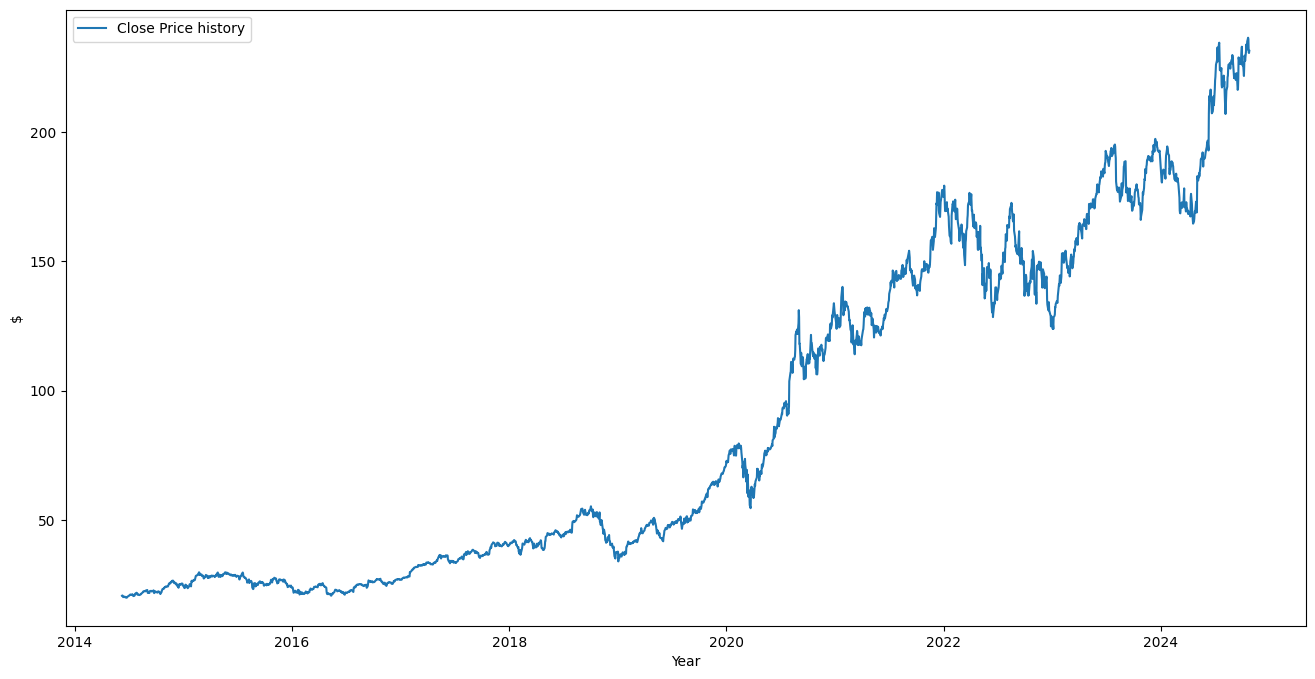

In [20]:
fig = plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("$")
plt.plot(df['Close'], label='Close Price history')
plt.legend()
plt.show()

In [21]:
df.dtypes
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2615.000000,2615.000000,2615.000000,2615.000000,2.615000e+03,2615.000000,2615.000000
mean,87.892039,88.829697,87.007741,87.961967,1.234132e+08,0.002926,0.004207
std,63.584850,64.251543,62.954446,63.639452,7.236162e+07,0.023772,0.157634
min,19.925417,20.033647,19.801726,19.940887,2.404830e+07,0.000000,0.000000
25%,29.257373,29.453493,29.042805,29.232646,7.450635e+07,0.000000,0.000000
50%,52.919338,53.418787,52.350006,52.928864,1.047684e+08,0.000000,0.000000
75%,146.526344,147.964488,145.089542,146.647537,1.524790e+08,0.000000,0.000000
max,236.206595,237.490005,234.449997,236.479996,7.593852e+08,0.250000,7.000000


In [22]:
df.reset_index(level="Date", inplace=True)
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [23]:
data = df.sort_index(ascending=True, axis=0)
df1 = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    df1["Date"][i] = data['Date'][i]
    df1["Close"][i] = data["Close"][i]

df1.index = df1.Date
df1.drop("Date", axis=1, inplace=True)
df1.head()

,Close
Date,
2014-06-09 00:00:00-04:00,20.696281
2014-06-10 00:00:00-04:00,20.81776
2014-06-11 00:00:00-04:00,20.731621
2014-06-12 00:00:00-04:00,20.384848
2014-06-13 00:00:00-04:00,20.161755


In [24]:
data = df1.values
train = data[0:1750, :]
test = data[1750:, :]

print(train.shape)
print(test.shape)

(1750, 1)
(865, 1)


In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [26]:
x_train, y_train = [], []
window = 60

for i in range(window, len(train)):
    x_train.append(scaled_data[i-window:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(window, inputs.shape[0]):
    x_test.append(inputs[i-window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(x_train, y_train, epochs=2, batch_size=64, verbose=2)

Epoch 1/2
27/27 - 6s - 210ms/step - loss: 0.0062
Epoch 2/2
27/27 - 1s - 52ms/step - loss: 2.7181e-04


In [31]:
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [32]:
mse = math.sqrt(mean_squared_error(test, closing_price))
print(f"Root Mean Squared Error: {mse}")

Root Mean Squared Error: 7.2364614939707375


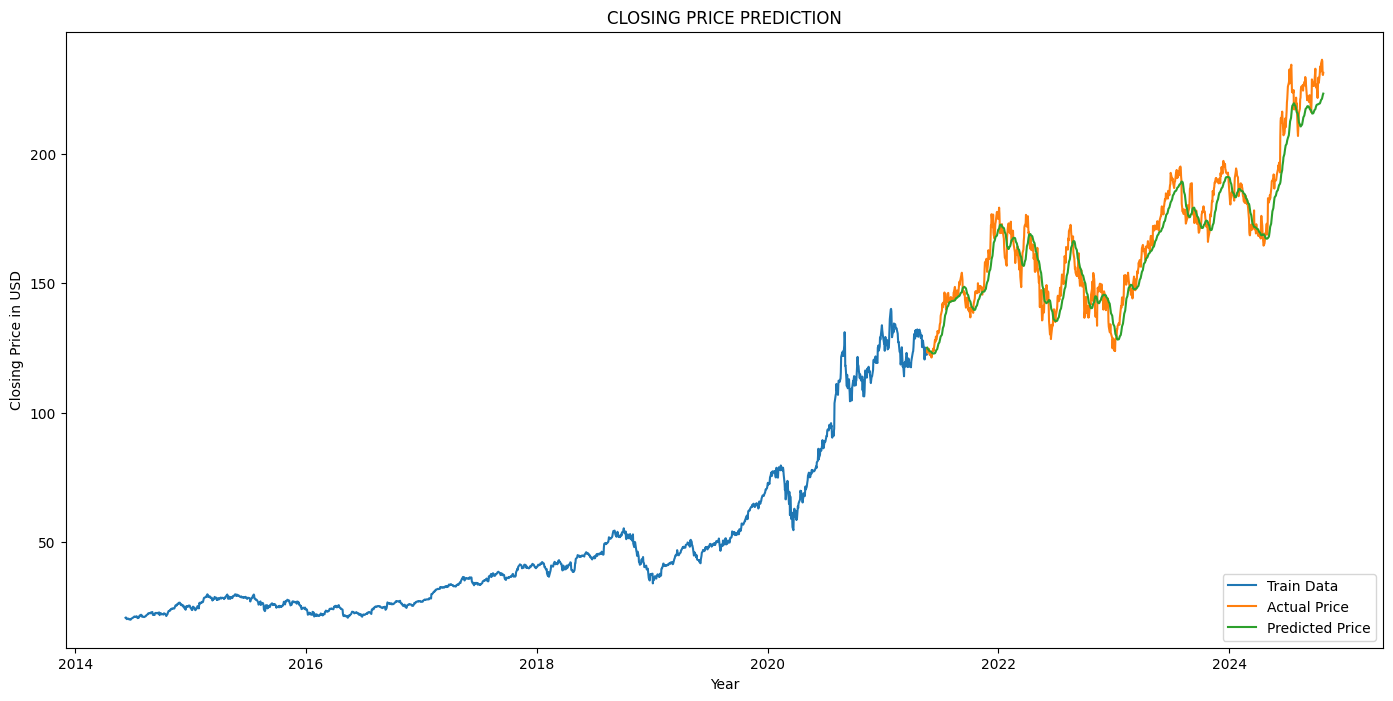

In [33]:
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.title("CLOSING PRICE PREDICTION")
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc="lower right")
plt.show()